### standard imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model import Model
from tqdm import tqdm
from torch import Tensor
from botorch.acquisition.active_learning import (
    MCSampler,
    qNegIntegratedPosteriorVariance,
)

from botorch.fit import fit_gpytorch_mll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer,StandardScaler
from botorch.models.gp_regression import SingleTaskGP

from sklearn.metrics import mean_absolute_error
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood

# from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
# from botorch.fit import fit_fully_bayesian_model_nuts
# from gpytorch.likelihoods.likelihood import Likelihood
# from gpytorch.means.constant_mean import ConstantMean
# from gpytorch.means.mean import Mean
# from gpytorch.models.exact_gp import ExactGP
from botorch.models import SingleTaskGP
import os 

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import warnings


# warnings.filterwarnings("ignore", category=botorch.exceptions.BotorchWarning)

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )

### checking my working directory so i can make sure to import my data file correctly


In [2]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/qNIPV/notebooks'

In [3]:
df = pd.read_csv('../datasets/AutoAM_dataset.csv')
df

,Prime Delay,Print Speed,X Offset Correction,Y Offset Correction,Score
0,0.000000,1.000000,0.000000,0.000000,0.339554
1,2.500000,3.000000,0.100000,0.100000,0.000000
2,5.000000,5.000000,-0.100000,-0.100000,0.218576
3,0.000000,0.999931,0.000006,0.000025,0.368919
4,0.000000,5.070133,0.225151,1.000000,0.000000
...,...,...,...,...,...
95,0.742365,1.714610,-0.380317,-0.416497,0.829756
96,0.000000,1.585934,-0.337143,-0.372811,0.922120
97,0.000000,1.568030,-0.335316,-0.365804,0.901296
98,0.000000,1.558826,-0.349834,-0.328645,0.936549


### converting my data into a tensor / and normalizing 

In [95]:
x_vals = df.iloc[:,:-1]
x_tensors = Tensor(x_vals.values)
x_tensors.shape

y_tensors = Tensor(df.iloc[:,-1].values)

normalizer = Normalizer()
standardizer = StandardScaler()

x = normalizer.fit_transform(x_tensors)
y = standardizer.fit_transform(y_tensors.reshape(-1,1))

### i split the data here into a candidate set and an initial set

In [5]:

# # First split: Separate out the candidate set
# x_temp, x_candidate, y_temp, y_candidate = train_test_split(
#     x, y, test_size=0.70, random_state=42) 

# # Second split: Divide the remaining data into training and test sets
# x_initial, x_test, y_initial, y_test = train_test_split(
#     x_temp, y_temp, test_size=0.90, random_state=42)  


# print("X_temp:", x_temp.shape, y_temp.shape)
# print("Candidate Set:", x_candidate.shape, y_candidate.shape)
# print("Initial Set:", x_initial.shape, y_initial.shape)
# print("Test Set:", x_test.shape, y_test.shape)


X_temp: (30, 4) (30, 1)
Candidate Set: (70, 4) (70, 1)
Initial Set: (3, 4) (3, 1)
Test Set: (27, 4) (27, 1)


In [ ]:
xcandidates, ycandidates, xtest, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

### for the acquisition function we need to use monte carlo points 

In [6]:
# mps_device = torch.device("cpu")
torch.manual_seed(0)
# mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
mps_device = torch.device("cpu")
dtype = torch.double

mcp = torch.quasirandom.SobolEngine(4, seed=0,scramble=True).draw_base2(9).to(device=mps_device, dtype=dtype)
mcp

tensor([[0.4751, 0.5925, 0.4945, 0.3139],
        [0.8106, 0.4339, 0.7125, 0.8734],
        [0.5718, 0.9770, 0.2237, 0.0569],
        ...,
        [0.5736, 0.0092, 0.3191, 0.8112],
        [0.8088, 0.5911, 0.8695, 0.1198],
        [0.4733, 0.4372, 0.0875, 0.5681]], dtype=torch.float64)

### we set the bounds here from 0 being the min and 1 being the max

In [7]:
bounds = torch.tensor([[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]], device=mps_device, dtype=dtype)

In [8]:
#convert array to tensor
x_init = torch.tensor(x_initial, device=mps_device, dtype=dtype)
x_init

y_init = torch.tensor(y_initial, device=mps_device, dtype=dtype)
y_init

xtest = torch.tensor(x_test, device=mps_device, dtype=dtype)
ytest = torch.tensor(y_test, device=mps_device, dtype=dtype)

x_candidates = torch.tensor(x_candidate, device=mps_device, dtype=dtype)
y_candidates = torch.tensor(y_candidate, device=mps_device, dtype=dtype)

In [10]:
print(x_init.shape)
print(y_init.shape)
print(xtest.shape)
print(ytest.shape)
print(x_candidates.shape)
print(y_candidates.shape)


torch.Size([3, 4])
torch.Size([3, 1])
torch.Size([27, 4])
torch.Size([27, 1])
torch.Size([70, 4])
torch.Size([70, 1])


### funtion to find the best predicted point from the acquisiton function

In [9]:
def find_max_normalized_acqval(tensor_list, qNIVP):
    max_value = None
    max_index = -1
    acq_val_lst = []
    # torch.manual_seed(13)
    for i, tensor_ in enumerate(tensor_list):
        tensor = tensor_.unsqueeze(0)
        qNIVP_val = qNIVP(tensor)
        acq_val_lst.append(qNIVP_val.item())  # Assuming it's a scalar tensor

        # Check if this is the maximum value so far
        if max_value is None or qNIVP_val > max_value:
            max_value = qNIVP_val
            max_index = i

    return max_value, max_index, acq_val_lst

In [10]:
xcandidates = x_candidates.clone()
ycandidates = y_candidates.clone()

xinit = x_init.clone()
yinit = y_init.clone()

### qNIVP runs (this is for the acquition function runs)

In [ ]:
rand_selection_mae = []
xmax_candidates = []
pred_mae = []
pred_y = []
pred_std = []



gp = SingleTaskGP(xinit, yinit)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)
posterior = gp(xtest)
ypred = posterior.mean.detach().numpy()
ystd = posterior.stddev.detach().numpy()

pred_y.append(ypred)
pred_std.append(ystd)


# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel


# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)


for i in tqdm(range(25)):
    # if not xcandidates:
    #     break
    
    qNIVP = qNegIntegratedPosteriorVariance(gp, mc_points= mcp)
    
    
    max_value, max_index, acq_val_lst = find_max_normalized_acqval(xcandidates, qNIVP)
    xmax_candidates.append(max_index)
    print("len of tensor:",len(xcandidates[max_index]))
    print("tensor shape:",xcandidates[max_index].shape)
    print("candidate tensor",xcandidates[max_index])
    print("shape of xinit:",xinit.shape)
    # add the new point to the training set
    
    
    xinit= torch.cat((xinit, xcandidates[max_index].unsqueeze(0)), 0)
    yinit = torch.cat((yinit, ycandidates[max_index].unsqueeze(0)), 0)
    
    print('len of new train:', len(xinit))
        
    xcandidates = torch.cat((xcandidates[:max_index], xcandidates[max_index + 1:]))
    ycandidates = torch.cat((ycandidates[:max_index], ycandidates[max_index + 1:]))
    
    
    gp = SingleTaskGP(xinit, yinit) 
    # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    ypred = gp(xtest)
    ypred_mean = ypred.mean.detach().numpy()
    pred_y.append(ypred_mean)

    #calculate the mean absolute error and the standard deviation for the test set
    ymae = mean_absolute_error(ytest, ypred_mean)
    print('mean absolute error: ', ymae)
    pred_mae.append(ymae)
    ystd = gp(xtest).stddev
    ystd = ystd.detach().numpy()
    pred_std.append(ystd)


In [15]:
qnivp_umap = xinit.clone()

tensor([[ 6.3977e-01,  7.6772e-01,  2.5591e-02,  2.5591e-02],
        [ 0.0000e+00,  9.6595e-01, -2.2039e-01, -1.3552e-01],
        [ 1.9274e-01,  9.7814e-01, -7.2046e-02, -3.0160e-02],
        [ 7.7404e-01,  5.9408e-01,  1.5481e-01,  1.5481e-01],
        [ 0.0000e+00,  7.0535e-02,  7.0535e-01,  7.0535e-01],
        [ 0.0000e+00,  9.2491e-01,  7.9426e-02,  3.7179e-01],
        [ 9.9243e-01,  3.1656e-02, -9.0575e-02,  7.6614e-02],
        [ 4.4473e-01,  8.8947e-01, -5.6154e-02,  8.8947e-02],
        [ 4.4368e-01,  8.8736e-01,  8.8736e-02, -8.8736e-02],
        [ 4.4516e-01,  8.9033e-01, -3.4951e-02, -8.9033e-02],
        [ 0.0000e+00,  9.8017e-01,  4.3527e-02,  1.9332e-01],
        [ 9.7966e-01,  1.9593e-02,  3.8510e-02, -1.9593e-01],
        [ 0.0000e+00,  9.8714e-01, -3.4760e-02,  1.5605e-01],
        [ 6.9256e-01,  7.0652e-01, -4.4742e-02, -1.3851e-01],
        [ 0.0000e+00,  1.0000e+00,  5.5404e-06,  2.5202e-05],
        [ 9.7944e-01,  1.9589e-02, -4.4077e-02, -1.9589e-01],
        

### now we run it using just random selection

In [16]:
xcandidates_rand = x_candidates.clone()
ycandidates_rand = y_candidates.clone()

xinit_rand = x_init.clone()
yinit_rand = y_init.clone()

In [ ]:
import random
torch.manual_seed(13)
random.seed(1000)

rand_xmax_candidates = []
rand_pred_mae = []
rand_pred_std = []
rand_pred_mean = []

# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel
random_mae_seeds =[]

# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
random_seeds = [0,13,90,14,12]
for seed in random_seeds:
    random.seed(seed)
    xcandidates_rand = x_candidates.clone()
    ycandidates_rand = y_candidates.clone()

    xinit_rand = x_init.clone()
    yinit_rand = y_init.clone()
    
    rand_xmax_candidates = []
    rand_pred_mae = []
    rand_pred_std = []
    rand_pred_mean = []

    gp = SingleTaskGP(xinit_rand, yinit_rand) 
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    rand_ypred = gp(xtest)
    rand_ypred_mean = rand_ypred.mean.detach().numpy()
    rand_pred_mean.append(rand_ypred_mean)
    #calculate the mean absolute error and the standard deviation for the test set
    rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
    print('mean absolute error: ', rand_ymae)
    rand_pred_mae.append(rand_ymae)
        
    rand_ystd = gp(xtest).stddev
    ystd_ = rand_ystd.detach().numpy()
    rand_pred_std.append(ystd_)
    print("initial len of xinit", len(xinit_rand))
    
    
    
    for i in tqdm(range(25)):
        # if xcandidates_rand.numel() == 0:
        #     break
        
        # Randomly select an index
        rand_select = random.randint(0, len(xcandidates_rand) - 1)
        
        # Add the selected tensor to the training sets
        xinit_rand = torch.cat((xinit_rand, xcandidates_rand[rand_select].unsqueeze(0)), 0)
        yinit_rand = torch.cat((yinit_rand, ycandidates_rand[rand_select].unsqueeze(0)), 0)
        
        # Print the length of new training set
        print('len of new train:', len(xinit_rand))

        # Remove the selected tensor from xcandidates and ycandidates
        xcandidates_rand = torch.cat((xcandidates_rand[:rand_select], xcandidates_rand[rand_select + 1:]))
        ycandidates_rand = torch.cat((ycandidates_rand[:rand_select], ycandidates_rand[rand_select + 1:]))
        
        # Update GP model, fit and predict
        gp = SingleTaskGP(xinit_rand, yinit_rand) 
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        
        # Predict the y values for the test set and calculate errors
        rand_ypred = gp(xtest)
        rand_ypred_mean = rand_ypred.mean.detach().numpy()
        rand_pred_mean.append(rand_ypred_mean)
        
        rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
        print('mean absolute error: ', rand_ymae)
        rand_pred_mae.append(rand_ymae)
        
        rand_ystd = gp(xtest).stddev
        ystd_ = rand_ystd.detach().numpy()
        rand_pred_std.append(ystd_)
    random_mae_seeds.append(rand_pred_mae)


In [19]:
xinit_rand

tensor([[ 6.3977e-01,  7.6772e-01,  2.5591e-02,  2.5591e-02],
        [ 0.0000e+00,  9.6595e-01, -2.2039e-01, -1.3552e-01],
        [ 1.9274e-01,  9.7814e-01, -7.2046e-02, -3.0160e-02],
        [ 0.0000e+00,  9.8840e-01, -7.8516e-02, -1.2996e-01],
        [ 0.0000e+00,  9.4776e-01, -1.9045e-01, -2.5590e-01],
        [ 0.0000e+00,  9.5340e-01, -2.0388e-01, -2.2242e-01],
        [ 0.0000e+00,  7.0535e-02,  7.0535e-01,  7.0535e-01],
        [ 0.0000e+00,  9.6252e-02, -2.5357e-01, -9.6252e-01],
        [ 0.0000e+00,  1.0000e+00,  5.5404e-06,  2.5202e-05],
        [ 3.8148e-01,  9.1340e-01, -7.0271e-02, -1.2344e-01],
        [ 0.0000e+00,  2.5190e-01, -9.6554e-01, -6.5375e-02],
        [ 6.0939e-01,  7.8779e-01, -5.7503e-02, -6.8735e-02],
        [ 7.3033e-01,  6.6399e-01, -6.6323e-02, -1.4607e-01],
        [ 2.7024e-01,  9.5445e-01, -1.0176e-01, -7.5064e-02],
        [ 7.7404e-01,  5.9408e-01,  1.5481e-01,  1.5481e-01],
        [ 0.0000e+00,  9.2491e-01,  7.9426e-02,  3.7179e-01],
        

In [18]:
random_umap = xinit_rand.clone()

In [71]:
len(random_mae_seeds[0])

26

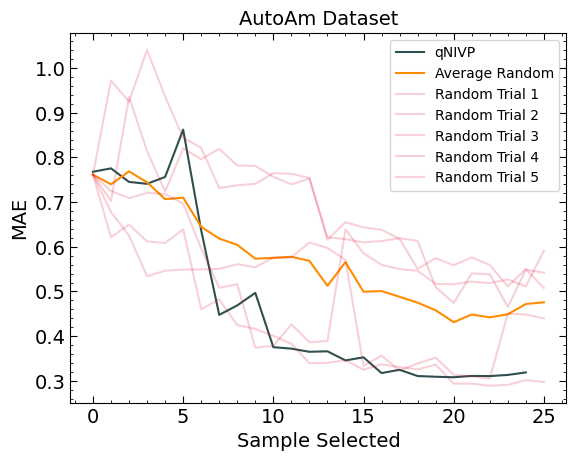

In [18]:
average_mae = np.mean(random_mae_seeds, axis=0)
random_trials = [1,2,3,4,5]

plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(average_mae, color='darkorange', label='Average Random')
colors = ['crimson','crimson','crimson','crimson','crimson']
for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
    plt.plot(mae_values, label=f'Random Trial {seed}', color=color,alpha=0.2)

plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('AutoAm Dataset', size=14)
plt.xlabel('Sample Selected', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

In [20]:
xcandidates_comit = x_candidates.clone()
ycandidates_comit = y_candidates.clone()

xinit_comit = x_init.clone()
yinit_comit = y_init.clone()

In [116]:
len(xcandidates_comit)

70

In [21]:
import warnings
warnings.filterwarnings("ignore")

# Your scikit-learn code here
gp_commit_lst = []
# Define a committee of regression models
committee = [
    RandomForestRegressor(),
    SVR(),
    DecisionTreeRegressor()
]

comit_pred_mae = []

# gp = SingleTaskGP(xinit_comit, yinit_comit)
# mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
# fit_gpytorch_mll(mll)
# posterior = gp(xtest)
# ypred = posterior.mean.detach().numpy()
    
# # gp_commit_lst.append(ypred)
# comitt_ymae = mean_absolute_error(ytest, ypred)
# gp_commit_lst.append(comitt_ymae)

# print(f'length of gp_commit_lst: {len(gp_commit_lst)}')

# create random seeds for models
# random_seeds = [0,13,90,14,12]
commit_seeds = []
# pick the top 25 best samples 
random_seeds = [0,13,90,14,12]
for seed in random_seeds:
    random.seed(seed)
    xcandidates_comit = x_candidates.clone()
    ycandidates_comit = y_candidates.clone()

    xinit_comit = x_init.clone()
    yinit_comit = y_init.clone()
    gp_commit_lst = []
    
    
    gp = SingleTaskGP(xinit_comit, yinit_comit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    
    # gp_commit_lst.append(ypred)
    comitt_ymae = mean_absolute_error(ytest, ypred)
    gp_commit_lst.append(comitt_ymae)
    for i in range(25):
        # print(f'this is {i}')
        # fit all 3 models 
        for model in committee:
            # print(model)
            model.fit(xinit_comit, yinit_comit)

    # Make predictions on the unlabeled data for each model in the committee
        predictions = np.array([model.predict(xcandidates_comit) for model in committee])

    # Measure disagreement: calculate variance across the predictions of the committee for each data point
        disagreement_scores = np.var(predictions, axis=0)
        # print(f'disagreement_scores: {disagreement_scores}')

    # # Select the top N most uncertain points (highest disagreement)
        N = 1  # Number of points to query
        top_N_indices = np.argsort(disagreement_scores)[-N:]

    # # The selected data points to query for labels
        X_to_query = xcandidates_comit[top_N_indices]
        
        ylabel = ycandidates_comit[top_N_indices]
        
        xinit_comit = torch.cat((xinit_comit, X_to_query), 0)
        yinit_comit = torch.cat((yinit_comit, ylabel), 0)
        
        xcandidates_comit = torch.cat((xcandidates_comit[:int(top_N_indices)], xcandidates_comit[int(top_N_indices) + 1:]))
        # print(f'len of x candidates: {len(xcandidates_comit)}')
        ycandidates_comit = torch.cat((ycandidates_comit[:int(top_N_indices)], ycandidates_comit[int(top_N_indices) + 1:]))
        
        
        # for model in committee:
        #     model.fit(xinit_comit, yinit_comit)

        # # Make predictions on the test set
        # predictions = np.array([model.predict(xtest) for model in committee])
        # ypred_comit = np.mean(predictions, axis=0)
        # mae_comit = mean_absolute_error(ytest, ypred_comit)
        # # print(f'Mean Absolute Error: {mae_comit}')

        # comit_pred_mae.append(mae_comit)
        # ------------
        
        gp = SingleTaskGP(xinit_comit, yinit_comit)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        posterior = gp(xtest)
        ypred = posterior.mean.detach().numpy()
            
        comitt_ymae = mean_absolute_error(ytest, ypred)
        gp_commit_lst.append(comitt_ymae)
        # print(f'length of gp_commit_lst: {len(gp_commit_lst)}')
    commit_seeds.append(gp_commit_lst)
    
    
    


In [22]:
commit_umap = xinit_comit.clone()

In [82]:
len(commit_seeds)

5

In [96]:
average_mae_commit = np.mean(commit_seeds, axis=0)


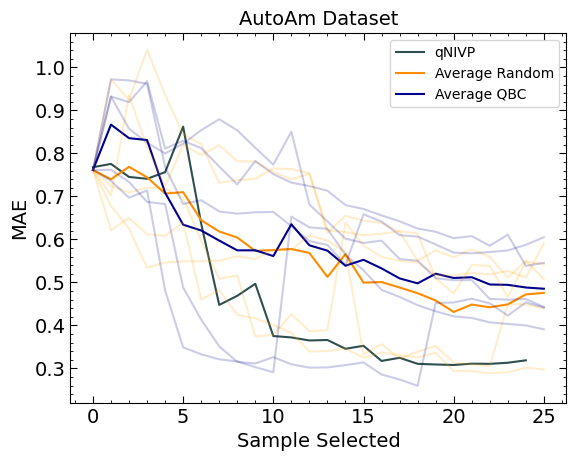

In [103]:
average_mae_commit = np.mean(commit_seeds, axis=0)
average_mae = np.mean(random_mae_seeds, axis=0)
random_trials = [1,2,3,4,5]

plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(average_mae, color='darkorange', label='Average Random')
plt.plot(average_mae_commit, color='darkblue', label='Average QBC')
# colors = ['crimson','crimson','crimson','crimson','crimson']
colors = ['orange','orange','orange','orange','orange']
color_ = ['darkblue','darkblue','darkblue','darkblue','darkblue']

# for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
#     plt.plot(mae_values, label=f'Random Trial {seed}', color=color,alpha=0.2)
    
# for mae_values, seed, color_ in zip(commit_seeds, random_trials, color_):
#     plt.plot(mae_values, label=f'Committee Trial {seed}', color=color_,alpha=0.2)


for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
    plt.plot(mae_values, color=color,alpha=0.2)
    
for mae_values, seed, color_ in zip(commit_seeds, random_trials, color_):
    plt.plot(mae_values, color=color_,alpha=0.2)

plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('AutoAm Dataset', size=14)
plt.xlabel('Sample Selected', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

### uncertainty sampling

In [ ]:
xcandidates_uncr = x_candidates.clone()
ycandidates_uncr = y_candidates.clone()

xinit_uncr = x_init.clone()
yinit_uncr = y_init.clone()

In [72]:
import torch
import random
from sklearn.metrics import mean_absolute_error
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from tqdm import tqdm

# Setting random seeds
torch.manual_seed(13)
random.seed(1000)

# Initialize storage for results
uncr_xmax_candidates = []
uncr_pred_mae = []
uncr_pred_std = []
uncr_pred_mean = []
unc_rand_mae_seeds = []

# Random seeds for repeatability
random_seeds = [0, 13, 90, 14, 12]

for seed in random_seeds:
    random.seed(seed)
    
    # Clone the candidate and initial datasets to avoid modifying the original
    xcandidates_uncr = x_candidates.clone()
    ycandidates_uncr = y_candidates.clone()
    xinit_uncr = x_init.clone()
    yinit_uncr = y_init.clone()

    # Initialize lists to store intermediate results
    uncr_xmax_candidates = []
    uncr_pred_mae = []
    uncr_pred_std = []
    uncr_pred_mean = []

    # Train the initial GP model on the initial training set
    gp = SingleTaskGP(xinit_uncr, yinit_uncr)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Predict on the test set initially
    uncr_ypred = gp(xtest)
    uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
    uncr_pred_mean.append(uncr_ypred_mean)
    
    # Calculate the initial mean absolute error (MAE) for the test set
    uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
    print('Initial mean absolute error: ', uncr_ymae)
    uncr_pred_mae.append(uncr_ymae)
    
    # Calculate and store the initial standard deviation for the test set predictions
    uncr_ystd = gp(xtest).stddev.detach().numpy()
    uncr_pred_std.append(uncr_ystd)
    print("Initial length of xinit", len(xinit_uncr))

    # Active learning loop (25 iterations)
    for i in tqdm(range(25)):
        # Predict the uncertainty (posterior stddev) for all candidate points
        posterior_candidates = gp(xcandidates_uncr)
        uncertainties = posterior_candidates.stddev.detach().numpy()  # Extract the standard deviation (uncertainty)

        # Find the index of the candidate point with the highest uncertainty
        max_uncertainty_idx = uncertainties.argmax()

        # Add the selected candidate (with the highest uncertainty) to the training set
        xinit_uncr = torch.cat((xinit_uncr, xcandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)
        yinit_uncr = torch.cat((yinit_uncr, ycandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)

        # Print the length of the new training set
        print('Length of new training set:', len(xinit_uncr))

        # Remove the selected candidate from the candidate set
        xcandidates_uncr = torch.cat((xcandidates_uncr[:max_uncertainty_idx], xcandidates_uncr[max_uncertainty_idx + 1:]))
        ycandidates_uncr = torch.cat((ycandidates_uncr[:max_uncertainty_idx], ycandidates_uncr[max_uncertainty_idx + 1:]))

        # Retrain the GP model on the updated training set
        gp = SingleTaskGP(xinit_uncr, yinit_uncr)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Predict the y values for the test set
        uncr_ypred = gp(xtest)
        uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
        uncr_pred_mean.append(uncr_ypred_mean)

        # Calculate the mean absolute error (MAE) for the test set
        uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
        print(f'Iteration {i}: mean absolute error = {uncr_ymae}')
        uncr_pred_mae.append(uncr_ymae)

        # Calculate and store the standard deviation (uncertainty) of the test set predictions
        uncr_ystd = gp(xtest).stddev.detach().numpy()
        uncr_pred_std.append(uncr_ystd)

    unc_rand_mae_seeds.append(uncr_pred_mae)


Initial mean absolute error:  0.7614795984793835
Initial length of xinit 3


 16%|█▌        | 4/25 [00:00<00:00, 37.78it/s]

Length of new training set: 4
Iteration 0: mean absolute error = 0.7736129868374513
Length of new training set: 5
Iteration 1: mean absolute error = 0.7527832547601391
Length of new training set: 6
Iteration 2: mean absolute error = 0.7598998353522219
Length of new training set: 7
Iteration 3: mean absolute error = 0.7562196065064403
Length of new training set: 8
Iteration 4: mean absolute error = 0.7766311253909066
Length of new training set: 9
Iteration 5: mean absolute error = 0.792671269951564
Length of new training set: 10
Iteration 6: mean absolute error = 0.7998257541317843
Length of new training set: 11


 48%|████▊     | 12/25 [00:00<00:00, 35.09it/s]

Iteration 7: mean absolute error = 0.7243186231815064
Length of new training set: 12
Iteration 8: mean absolute error = 0.6607890621828817
Length of new training set: 13
Iteration 9: mean absolute error = 0.6394783916690443
Length of new training set: 14
Iteration 10: mean absolute error = 0.6133233507798841
Length of new training set: 15
Iteration 11: mean absolute error = 0.4731341904435582
Length of new training set: 16
Iteration 12: mean absolute error = 0.5458260793887768
Length of new training set: 17
Iteration 13: mean absolute error = 0.5586645383617301
Length of new training set: 18


 80%|████████  | 20/25 [00:00<00:00, 29.19it/s]

Iteration 14: mean absolute error = 0.56716373941141
Length of new training set: 19
Iteration 15: mean absolute error = 0.5494842531946054
Length of new training set: 20
Iteration 16: mean absolute error = 0.5075101191886587
Length of new training set: 21
Iteration 17: mean absolute error = 0.3344764356423797
Length of new training set: 22
Iteration 18: mean absolute error = 0.3311866805960214
Length of new training set: 23
Iteration 19: mean absolute error = 0.31946305633294664
Length of new training set: 24


 92%|█████████▏| 23/25 [00:00<00:00, 25.90it/s]

Iteration 20: mean absolute error = 0.37780058063519667
Length of new training set: 25
Iteration 21: mean absolute error = 0.3708321817916641
Length of new training set: 26
Iteration 22: mean absolute error = 0.7381524498758795
Length of new training set: 27
Iteration 23: mean absolute error = 0.7120510105848338
Length of new training set: 28


100%|██████████| 25/25 [00:00<00:00, 28.04it/s]


Iteration 24: mean absolute error = 0.7114544419255759
Initial mean absolute error:  0.7614795984793835
Initial length of xinit 3


 20%|██        | 5/25 [00:00<00:00, 41.41it/s]

Length of new training set: 4
Iteration 0: mean absolute error = 0.7736129868374513
Length of new training set: 5
Iteration 1: mean absolute error = 0.7527832547601391
Length of new training set: 6
Iteration 2: mean absolute error = 0.7598998353522219
Length of new training set: 7
Iteration 3: mean absolute error = 0.7562196065064403
Length of new training set: 8
Iteration 4: mean absolute error = 0.7766311253909066
Length of new training set: 9
Iteration 5: mean absolute error = 0.792671269951564
Length of new training set: 10
Iteration 6: mean absolute error = 0.7998257541317843
Length of new training set: 11


 40%|████      | 10/25 [00:00<00:00, 38.42it/s]

Iteration 7: mean absolute error = 0.7243186231815064
Length of new training set: 12
Iteration 8: mean absolute error = 0.6607890621828817
Length of new training set: 13
Iteration 9: mean absolute error = 0.6394783916690443
Length of new training set: 14
Iteration 10: mean absolute error = 0.6133233507798841
Length of new training set: 15
Iteration 11: mean absolute error = 0.4731341904435582
Length of new training set: 16
Iteration 12: mean absolute error = 0.5458260793887768
Length of new training set: 17


 56%|█████▌    | 14/25 [00:00<00:00, 35.10it/s]

Iteration 13: mean absolute error = 0.5586645383617301
Length of new training set: 18


 72%|███████▏  | 18/25 [00:00<00:00, 30.47it/s]

Iteration 14: mean absolute error = 0.56716373941141
Length of new training set: 19
Iteration 15: mean absolute error = 0.5494842531946054
Length of new training set: 20
Iteration 16: mean absolute error = 0.5075101191886587
Length of new training set: 21
Iteration 17: mean absolute error = 0.3344764356423797
Length of new training set: 22


 88%|████████▊ | 22/25 [00:00<00:00, 22.00it/s]

Iteration 18: mean absolute error = 0.3311866805960214
Length of new training set: 23
Iteration 19: mean absolute error = 0.31946305633294664
Length of new training set: 24
Iteration 20: mean absolute error = 0.37780058063519667
Length of new training set: 25
Iteration 21: mean absolute error = 0.3708321817916641
Length of new training set: 26


100%|██████████| 25/25 [00:01<00:00, 23.51it/s]


Iteration 22: mean absolute error = 0.7381524498758795
Length of new training set: 27
Iteration 23: mean absolute error = 0.7120510105848338
Length of new training set: 28
Iteration 24: mean absolute error = 0.7114544419255759
Initial mean absolute error:  0.7614795984793835
Initial length of xinit 3


  0%|          | 0/25 [00:00<?, ?it/s]

Length of new training set: 4
Iteration 0: mean absolute error = 0.7736129868374513
Length of new training set: 5
Iteration 1: mean absolute error = 0.7527832547601391


 16%|█▌        | 4/25 [00:00<00:00, 33.88it/s]

Length of new training set: 6
Iteration 2: mean absolute error = 0.7598998353522219
Length of new training set: 7
Iteration 3: mean absolute error = 0.7562196065064403
Length of new training set: 8
Iteration 4: mean absolute error = 0.7766311253909066
Length of new training set: 9
Iteration 5: mean absolute error = 0.792671269951564
Length of new training set: 10
Iteration 6: mean absolute error = 0.7998257541317843
Length of new training set: 11


 32%|███▏      | 8/25 [00:00<00:00, 34.47it/s]

Iteration 7: mean absolute error = 0.7243186231815064
Length of new training set: 12


 48%|████▊     | 12/25 [00:00<00:00, 33.08it/s]

Iteration 8: mean absolute error = 0.6607890621828817
Length of new training set: 13
Iteration 9: mean absolute error = 0.6394783916690443
Length of new training set: 14
Iteration 10: mean absolute error = 0.6133233507798841
Length of new training set: 15
Iteration 11: mean absolute error = 0.4731341904435582
Length of new training set: 16
Iteration 12: mean absolute error = 0.5458260793887768
Length of new training set: 17
Iteration 13: mean absolute error = 0.5586645383617301
Length of new training set: 18
Iteration 14: mean absolute error = 0.56716373941141
Length of new training set: 19


 64%|██████▍   | 16/25 [00:00<00:00, 30.85it/s]

Iteration 15: mean absolute error = 0.5494842531946054
Length of new training set: 20
Iteration 16: mean absolute error = 0.5075101191886587
Length of new training set: 21
Iteration 17: mean absolute error = 0.3344764356423797
Length of new training set: 22
Iteration 18: mean absolute error = 0.3311866805960214
Length of new training set: 23


 80%|████████  | 20/25 [00:00<00:00, 27.80it/s]

Iteration 19: mean absolute error = 0.31946305633294664
Length of new training set: 24


 92%|█████████▏| 23/25 [00:00<00:00, 24.44it/s]

Iteration 20: mean absolute error = 0.37780058063519667
Length of new training set: 25
Iteration 21: mean absolute error = 0.3708321817916641
Length of new training set: 26
Iteration 22: mean absolute error = 0.7381524498758795
Length of new training set: 27
Iteration 23: mean absolute error = 0.7120510105848338
Length of new training set: 28


100%|██████████| 25/25 [00:00<00:00, 26.29it/s]


Iteration 24: mean absolute error = 0.7114544419255759
Initial mean absolute error:  0.7614795984793835
Initial length of xinit 3


 16%|█▌        | 4/25 [00:00<00:00, 38.86it/s]

Length of new training set: 4
Iteration 0: mean absolute error = 0.7736129868374513
Length of new training set: 5
Iteration 1: mean absolute error = 0.7527832547601391
Length of new training set: 6
Iteration 2: mean absolute error = 0.7598998353522219
Length of new training set: 7
Iteration 3: mean absolute error = 0.7562196065064403
Length of new training set: 8
Iteration 4: mean absolute error = 0.7766311253909066
Length of new training set: 9
Iteration 5: mean absolute error = 0.792671269951564
Length of new training set: 10
Iteration 6: mean absolute error = 0.7998257541317843
Length of new training set: 11


 32%|███▏      | 8/25 [00:00<00:00, 36.18it/s]

Iteration 7: mean absolute error = 0.7243186231815064
Length of new training set: 12
Iteration 8: mean absolute error = 0.6607890621828817
Length of new training set: 13
Iteration 9: mean absolute error = 0.6394783916690443
Length of new training set: 14
Iteration 10: mean absolute error = 0.6133233507798841
Length of new training set: 15


 48%|████▊     | 12/25 [00:00<00:00, 34.35it/s]

Iteration 11: mean absolute error = 0.4731341904435582
Length of new training set: 16
Iteration 12: mean absolute error = 0.5458260793887768
Length of new training set: 17


 64%|██████▍   | 16/25 [00:00<00:00, 30.65it/s]

Iteration 13: mean absolute error = 0.5586645383617301
Length of new training set: 18
Iteration 14: mean absolute error = 0.56716373941141
Length of new training set: 19
Iteration 15: mean absolute error = 0.5494842531946054
Length of new training set: 20
Iteration 16: mean absolute error = 0.5075101191886587
Length of new training set: 21
Iteration 17: mean absolute error = 0.3344764356423797
Length of new training set: 22


 80%|████████  | 20/25 [00:00<00:00, 24.17it/s]

Iteration 18: mean absolute error = 0.3311866805960214
Length of new training set: 23
Iteration 19: mean absolute error = 0.31946305633294664
Length of new training set: 24
Iteration 20: mean absolute error = 0.37780058063519667
Length of new training set: 25
Iteration 21: mean absolute error = 0.3708321817916641
Length of new training set: 26


100%|██████████| 25/25 [00:01<00:00, 24.40it/s]

Iteration 22: mean absolute error = 0.7381524498758795
Length of new training set: 27
Iteration 23: mean absolute error = 0.7120510105848338
Length of new training set: 28
Iteration 24: mean absolute error = 0.7114544419255759


Initial mean absolute error:  0.7614795984793835
Initial length of xinit 3


  0%|          | 0/25 [00:00<?, ?it/s]

Length of new training set: 4
Iteration 0: mean absolute error = 0.7736129868374513
Length of new training set: 5


 16%|█▌        | 4/25 [00:00<00:00, 32.04it/s]

Iteration 1: mean absolute error = 0.7527832547601391
Length of new training set: 6
Iteration 2: mean absolute error = 0.7598998353522219
Length of new training set: 7
Iteration 3: mean absolute error = 0.7562196065064403
Length of new training set: 8
Iteration 4: mean absolute error = 0.7766311253909066
Length of new training set: 9
Iteration 5: mean absolute error = 0.792671269951564
Length of new training set: 10
Iteration 6: mean absolute error = 0.7998257541317843
Length of new training set: 11


 48%|████▊     | 12/25 [00:00<00:00, 29.98it/s]

Iteration 7: mean absolute error = 0.7243186231815064
Length of new training set: 12
Iteration 8: mean absolute error = 0.6607890621828817
Length of new training set: 13
Iteration 9: mean absolute error = 0.6394783916690443
Length of new training set: 14
Iteration 10: mean absolute error = 0.6133233507798841
Length of new training set: 15
Iteration 11: mean absolute error = 0.4731341904435582
Length of new training set: 16
Iteration 12: mean absolute error = 0.5458260793887768
Length of new training set: 17


 64%|██████▍   | 16/25 [00:00<00:00, 28.95it/s]

Iteration 13: mean absolute error = 0.5586645383617301
Length of new training set: 18
Iteration 14: mean absolute error = 0.56716373941141
Length of new training set: 19
Iteration 15: mean absolute error = 0.5494842531946054
Length of new training set: 20
Iteration 16: mean absolute error = 0.5075101191886587
Length of new training set: 21
Iteration 17: mean absolute error = 0.3344764356423797
Length of new training set: 22


 76%|███████▌  | 19/25 [00:00<00:00, 27.08it/s]

Iteration 18: mean absolute error = 0.3311866805960214
Length of new training set: 23


 88%|████████▊ | 22/25 [00:00<00:00, 25.22it/s]

Iteration 19: mean absolute error = 0.31946305633294664
Length of new training set: 24
Iteration 20: mean absolute error = 0.37780058063519667
Length of new training set: 25
Iteration 21: mean absolute error = 0.3708321817916641
Length of new training set: 26


100%|██████████| 25/25 [00:01<00:00, 24.20it/s]

Iteration 22: mean absolute error = 0.7381524498758795
Length of new training set: 27
Iteration 23: mean absolute error = 0.7120510105848338
Length of new training set: 28
Iteration 24: mean absolute error = 0.7114544419255759


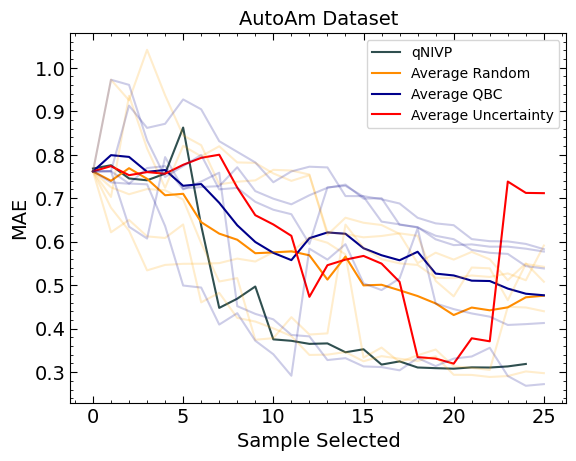

In [81]:
average_mae_uncr = np.mean(unc_rand_mae_seeds, axis=0)
average_mae_commit = np.mean(commit_seeds, axis=0)
average_mae = np.mean(random_mae_seeds, axis=0)
random_trials = [1,2,3,4,5]

plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(average_mae, color='darkorange', label='Average Random')
plt.plot(average_mae_commit, color='darkblue', label='Average QBC')
plt.plot(average_mae_uncr, color='red', label='Average Uncertainty')
# colors = ['crimson','crimson','crimson','crimson','crimson']
colors = ['orange','orange','orange','orange','orange']
color_ = ['darkblue','darkblue','darkblue','darkblue','darkblue']
# color__ = ['green','green','green','green','green']

# for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
#     plt.plot(mae_values, label=f'Random Trial {seed}', color=color,alpha=0.2)
    
# for mae_values, seed, color_ in zip(commit_seeds, random_trials, color_):
#     plt.plot(mae_values, label=f'Committee Trial {seed}', color=color_,alpha=0.2)


for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
    plt.plot(mae_values, color=color,alpha=0.2)
    
for mae_values, seed, color_ in zip(commit_seeds, random_trials, color_):
    plt.plot(mae_values, color=color_,alpha=0.2)
    
# for mae_values, seed, color_ in zip(random_seeds, random_trials, color_):
#     plt.plot(mae_values, color=color__,alpha=0.2)

plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('AutoAm Dataset', size=14)
plt.xlabel('Sample Selected', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

In [52]:
ytest_parity = ytest.squeeze().numpy()
ytest_parity.shape

(27,)

In [49]:
rand_ypred_mean.shape

(27,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


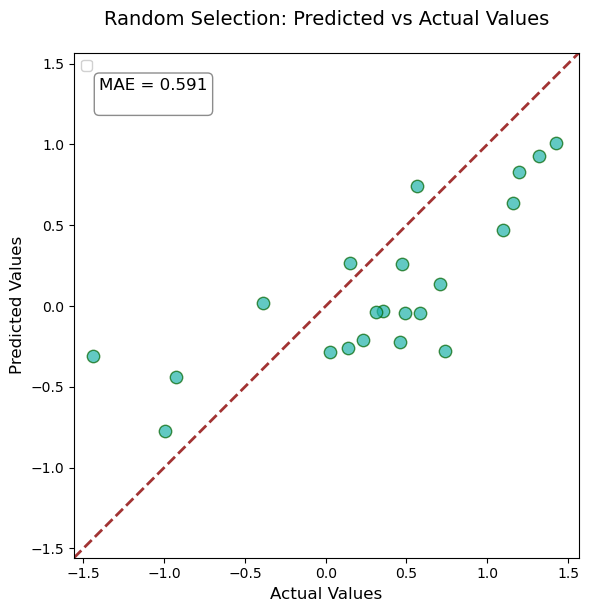

In [69]:
def create_detailed_parity_plot(y_test, y_pred, 
                              title="Prediction vs Actual",
                              xlabel="Actual Values", 
                              ylabel="Predicted Values",
                              point_color='cornflowerblue',
                              edge_color='navy',
                              line_color='red',
                              fontsize=12,
                              alpha=0.6,
                              point_size=100,
                              add_statistics=True,
                              grid_style='--',
                              grid_alpha=0.3):
    """
    Creates a detailed parity plot with customizable features.
    """
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Calculate range
    min_val = min(min(y_test), min(y_pred)) * 0.9
    max_val = max(max(y_test), max(y_pred)) * 1.1
    range_val = [min_val, max_val]
    
    # Plot parity line
    ax.plot(range_val, range_val, '--', color=line_color, alpha=0.8, linewidth=2, zorder=1)
    
    # Create scatter plot
    scatter = ax.scatter(y_test, y_pred, 
                        alpha=alpha,
                        c=point_color,
                        edgecolors=edge_color,
                        s=point_size,
                        zorder=2)
    
    if add_statistics:
        # Calculate statistics
        # r2 = np.corrcoef(y_test, y_pred)[0,1]**2
        mae = np.mean(np.abs(y_test - y_pred))
        # rmse = np.sqrt(np.mean((y_test - y_pred)**2))
        
        # Add statistics text
        # f'R² = {r2:.3f}\n'
        # f'RMSE = {rmse:.3f}'
        stats_text = (
                     f'MAE = {mae:.3f}\n'
                     )
        
        plt.text(0.05, 0.95, stats_text,
                transform=ax.transAxes,
                fontsize=fontsize,
                verticalalignment='top',
                bbox=dict(boxstyle='round',
                         facecolor='white',
                         alpha=0.9,
                         edgecolor='gray'))
    
    # Customize the plot
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+2, pad=20)
    
    # Make axes equal
    ax.set_aspect('equal')
    
    # Add grid
    # ax.grid(True, linestyle=grid_style, alpha=grid_alpha)
    
    # Set limits
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    # Add legend
    ax.legend(fontsize=fontsize-2, framealpha=0.9)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

# ytest, rand_ypred_mean
# Example usage with custom settings:
fig, ax = create_detailed_parity_plot(
    ytest_parity, 
    rand_ypred_mean,
    title="Random Selection: Predicted vs Actual Values",
    point_color='lightseagreen',
    edge_color='darkgreen',
    line_color='darkred',
    alpha=0.7,
    point_size=80,
    grid_alpha=0.2
)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


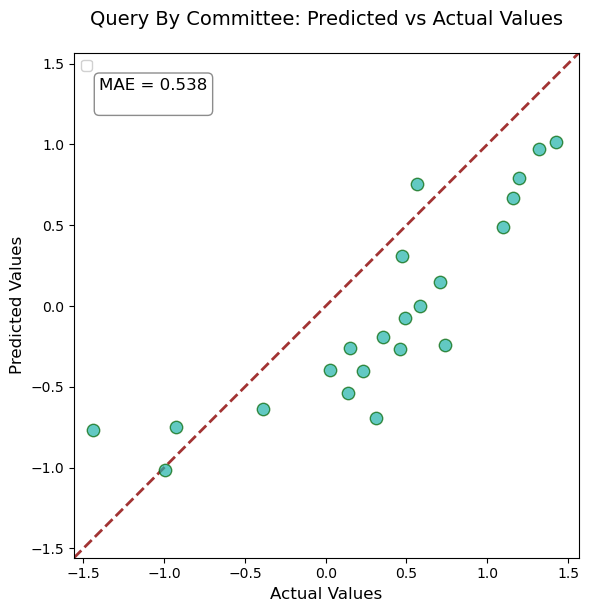

In [70]:
fig, ax = create_detailed_parity_plot(
    ytest_parity, 
    ypred,
    title="Query By Committee: Predicted vs Actual Values",
    point_color='lightseagreen',
    edge_color='darkgreen',
    line_color='darkred',
    alpha=0.7,
    point_size=80,
    grid_alpha=0.2
)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


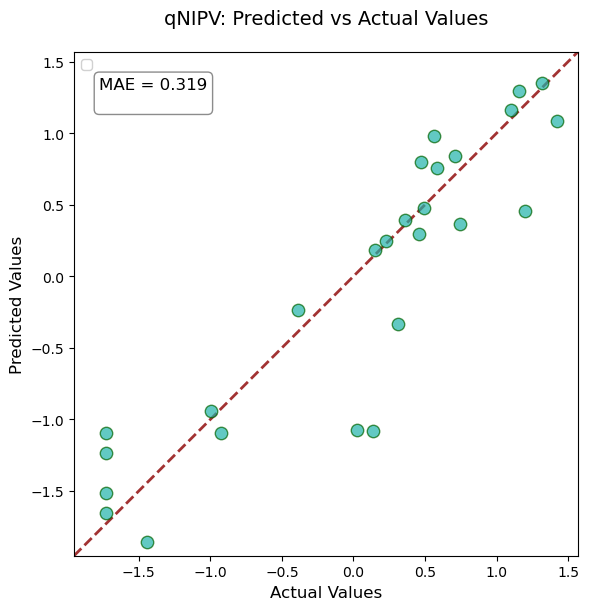

In [71]:
fig, ax = create_detailed_parity_plot(
    ytest_parity, 
    ypred_mean,
    title="qNIPV: Predicted vs Actual Values",
    point_color='lightseagreen',
    edge_color='darkgreen',
    line_color='darkred',
    alpha=0.7,
    point_size=80,
    grid_alpha=0.2
)
plt.show()

In [27]:
import numpy as np
import umap
import plotly.express as px
import plotly.graph_objects as go

# Assuming you have three tensors:
# tensor1, tensor2, tensor3

def plot_3d_umap_multiple_tensors(tensors, labels=None, colors=None):
    # Convert tensors to numpy arrays if they aren't already
    data_arrays = [tensor.numpy() if hasattr(tensor, 'numpy') else tensor for tensor in tensors]
    
    # Combine all data for UMAP
    combined_data = np.vstack(data_arrays)
    
    # Create labels for coloring
    if labels is None:
        labels = np.concatenate([np.full(len(data), i) for i, data in enumerate(data_arrays)])
    
    # Fit UMAP
    reducer = umap.UMAP(n_components=3, random_state=42)
    embedding = reducer.fit_transform(combined_data)
    
    # Split embedding back into separate groups
    start_idx = 0
    embeddings = []
    for data in data_arrays:
        end_idx = start_idx + len(data)
        embeddings.append(embedding[start_idx:end_idx])
        start_idx = end_idx

    # Using plotly for interactive 3D visualization
    fig = go.Figure()
    
    colors = colors or ['red', 'blue', 'green']
    
    # Add each tensor's points to the plot
    for i, emb in enumerate(embeddings):
        fig.add_trace(go.Scatter3d(
            x=emb[:, 0],
            y=emb[:, 1],
            z=emb[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=colors[i],
                opacity=0.8
            ),
            name=f'Tensor {i+1}'
        ))

    # Update the layout
    fig.update_layout(
        title='3D UMAP visualization of multiple tensors',
        scene=dict(
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            zaxis_title='UMAP 3'
        ),
        width=1000,
        height=500,
        showlegend=True
    )

    fig.show()

# Your existing tensors plus a new one
tensors = [qnivp_umap, random_umap, commit_umap, x_candidates]  # Add tensor4 to the list

# Add a new color for the fourth tensor
colors = ['red', 'blue', 'green', 'purple']  # Add a new color

# Call the function with the updated lists
plot_3d_umap_multiple_tensors(tensors, colors=colors)


# Example usage:
# tensors = [qnivp_umap, random_umap, commit_umap]
# colors = ['red', 'blue', 'green']
# plot_3d_umap_multiple_tensors(tensors, colors=colors)

In [40]:
def plot_3d_umap_multiple_tensors(tensors, labels=None, colors=None, marker_sizes=None, opacities=None):
    # Convert tensors to numpy arrays if they aren't already
    data_arrays = [tensor.numpy() if hasattr(tensor, 'numpy') else tensor for tensor in tensors]
    
    # Combine all data for UMAP
    combined_data = np.vstack(data_arrays)
    
    # Create labels for coloring
    if labels is None:
        labels = np.concatenate([np.full(len(data), i) for i, data in enumerate(data_arrays)])
    
    # Fit UMAP
    reducer = umap.UMAP(n_components=3, random_state=42)
    embedding = reducer.fit_transform(combined_data)
    
    # Split embedding back into separate groups
    start_idx = 0
    embeddings = []
    for data in data_arrays:
        end_idx = start_idx + len(data)
        embeddings.append(embedding[start_idx:end_idx])
        start_idx = end_idx

    # Using plotly for interactive 3D visualization
    fig = go.Figure()
    
    # Default values if not provided
    colors = colors or ['red', 'blue', 'green', 'purple']
    marker_sizes = marker_sizes or [5] * len(tensors)
    opacities = opacities or [0.8] * len(tensors)  # Default opacity for all tensors
    
    # Add each tensor's points to the plot
    for i, emb in enumerate(embeddings):
        fig.add_trace(go.Scatter3d(
            x=emb[:, 0],
            y=emb[:, 1],
            z=emb[:, 2],
            mode='markers',
            marker=dict(
                size=marker_sizes[i],
                color=colors[i],
                opacity=opacities[i]  # Individual opacity for each tensor
            ),
            name=f'Tensor {i+1}'
        ))

    # Update the layout
    fig.update_layout(
        title='3D UMAP visualization of multiple tensors',
        scene=dict(
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            zaxis_title='UMAP 3'
        ),
        width=1000,
        height=500,
        showlegend=True
    )
    
    fig.show()

# # Example usage:
# tensors = [qnivp_umap, random_umap, commit_umap, x_candidates]
# colors = ['purple', 'blue', 'green','red']
# marker_sizes = [5, 5, 5, 5]
# opacities = [0.7, 0.7, 0.7, 0.3]  # Different opacity for each tensor

tensors = [qnivp_umap, x_candidates]
colors = ['orange','red']
marker_sizes = [5, 5]
opacities = [1.0, 0.1]
plot_3d_umap_multiple_tensors(
    tensors, 
    colors=colors, 
    marker_sizes=marker_sizes, 
    opacities=opacities
)

In [45]:
tensors = [qnivp_umap, x_candidates,xtest]
colors = ['orange','red','purple']
marker_sizes = [5, 5,5]
opacities = [1.0, 0.3,1.0]
plot_3d_umap_multiple_tensors(
    tensors, 
    colors=colors, 
    marker_sizes=marker_sizes, 
    opacities=opacities
)

In [44]:
tensors = [random_umap, x_candidates,xtest]
colors = ['orange','red','purple']
marker_sizes = [5, 5,5]
opacities = [1.0, 0.3,1.0]
plot_3d_umap_multiple_tensors(
    tensors, 
    colors=colors, 
    marker_sizes=marker_sizes, 
    opacities=opacities
)

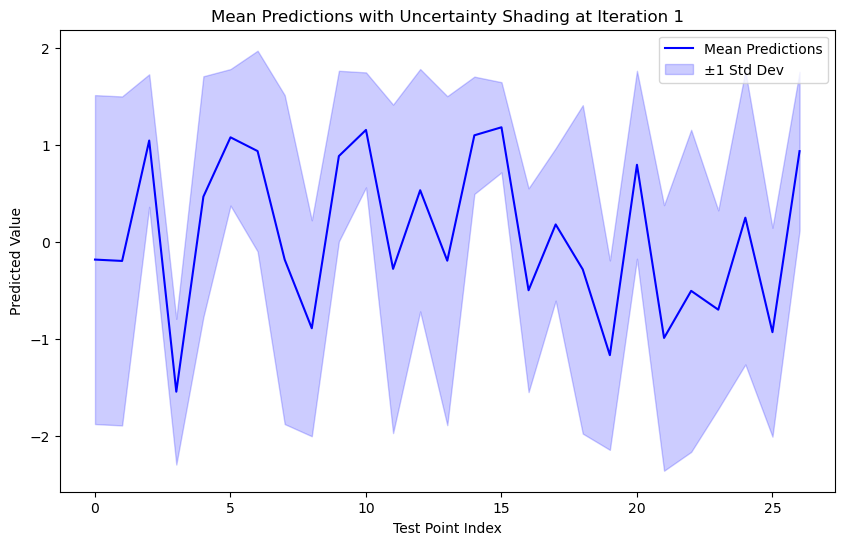

In [54]:
# Assuming you have numpy arrays from your previous discussion
pred_y_np = np.array(pred_y)  # mean predictions over iterations
pred_std_np = np.array(pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 0
means = pred_y_np[iteration_index]
std_devs = pred_std_np[iteration_index]

# Generate indices for x-axis
x_values = np.arange(len(means))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, means, label='Mean Predictions', color='blue')
plt.fill_between(x_values, means - std_devs, means + std_devs, color='blue', alpha=0.2, label='±1 Std Dev')

plt.title('Mean Predictions with Uncertainty Shading at Iteration {}'.format(iteration_index + 1))
plt.xlabel('Test Point Index')
plt.ylabel('Predicted Value')
plt.legend()
# plt.grid(True)
plt.show()



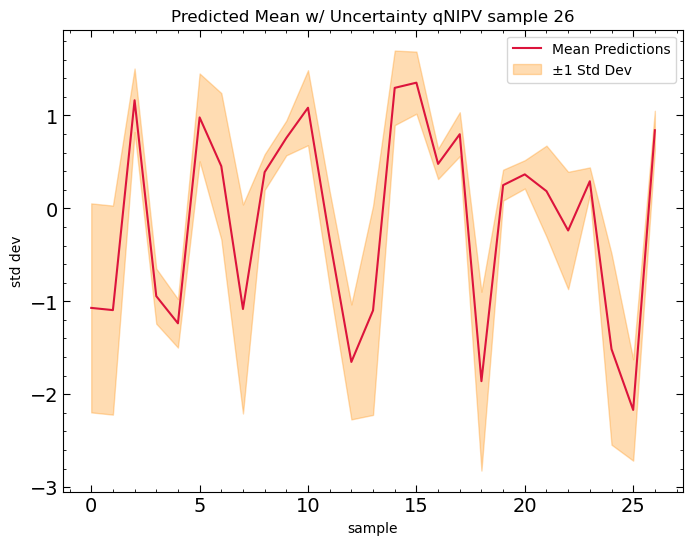

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have numpy arrays from your previous discussion
pred_y_np = np.array(pred_y)  # mean predictions over iterations
pred_std_np = np.array(pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 25
means = pred_y_np[iteration_index]
std_devs = pred_std_np[iteration_index]

# Generate indices for x-axis
x_values = np.arange(len(means))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values, means, label='Mean Predictions', color='crimson')
plt.fill_between(x_values, means - std_devs, means + std_devs, color='darkorange', alpha=0.3, label='±1 Std Dev')

plt.title('Predicted Mean w/ Uncertainty qNIPV sample {}'.format(iteration_index + 1))
plt.xlabel('sample')
plt.ylabel('std dev')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.legend()
# plt.grid(True)
plt.show()

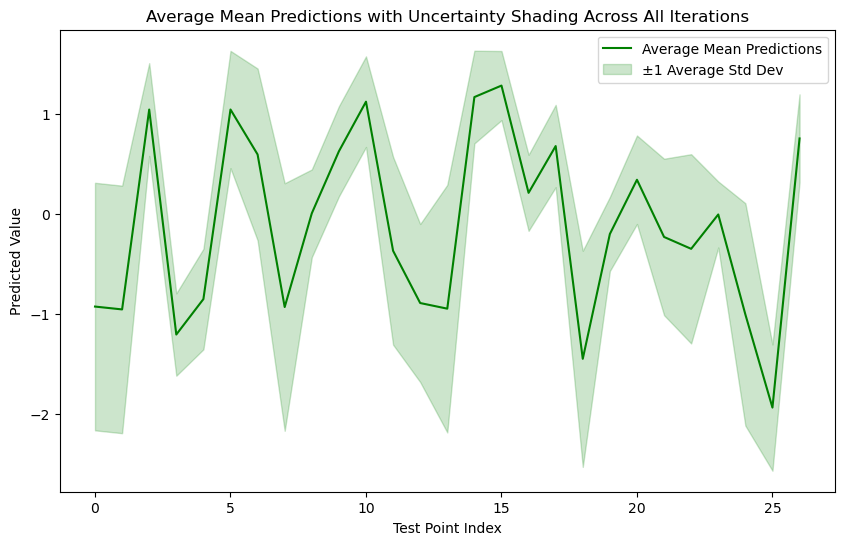

In [49]:
# Calculate average means and standard deviations across all iterations
average_means = np.mean(pred_y_np, axis=0)
average_stds = np.mean(pred_std_np, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, average_means, label='Average Mean Predictions', color='green')
plt.fill_between(x_values, average_means - average_stds, average_means + average_stds, color='green', alpha=0.2, label='±1 Average Std Dev')

plt.title('Average Mean Predictions with Uncertainty Shading Across All Iterations')
plt.xlabel('Samples Added')
plt.ylabel('STD')
plt.legend()
# plt.grid(True)
plt.show()


### random

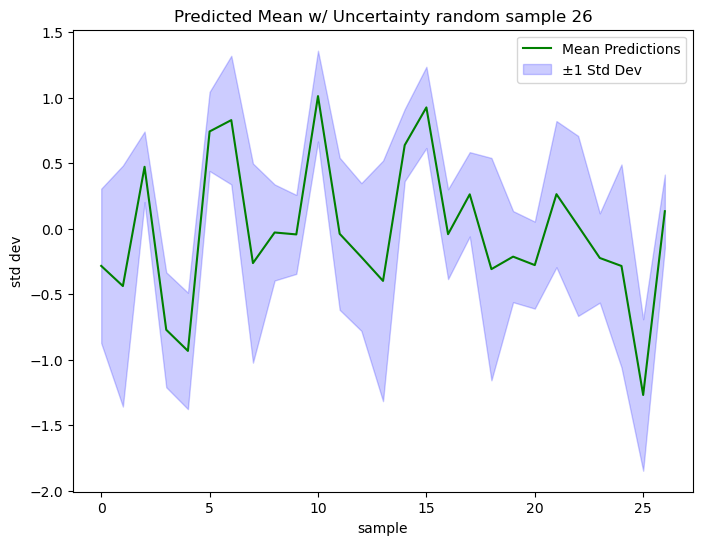

In [91]:
# Assuming you have numpy arrays from your previous discussion
rand_pred_y_np = np.array(rand_pred_mean)  # mean predictions over iterations
rand_pred_std_np = np.array(rand_pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 25
means_rand = rand_pred_y_np[iteration_index]
std_devs_rand = rand_pred_std_np[iteration_index]

# Generate indices for x-axis
x_values_rand = np.arange(len(means_rand))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values, means_rand, label='Mean Predictions', color='green')
plt.fill_between(x_values_rand, means_rand - std_devs_rand, means_rand + std_devs_rand, color='blue', alpha=0.2, label='±1 Std Dev')

plt.title('Predicted Mean w/ Uncertainty random sample {}'.format(iteration_index + 1))
plt.xlabel('sample')
plt.ylabel('std dev')
plt.legend()
# plt.grid(True)
plt.show()

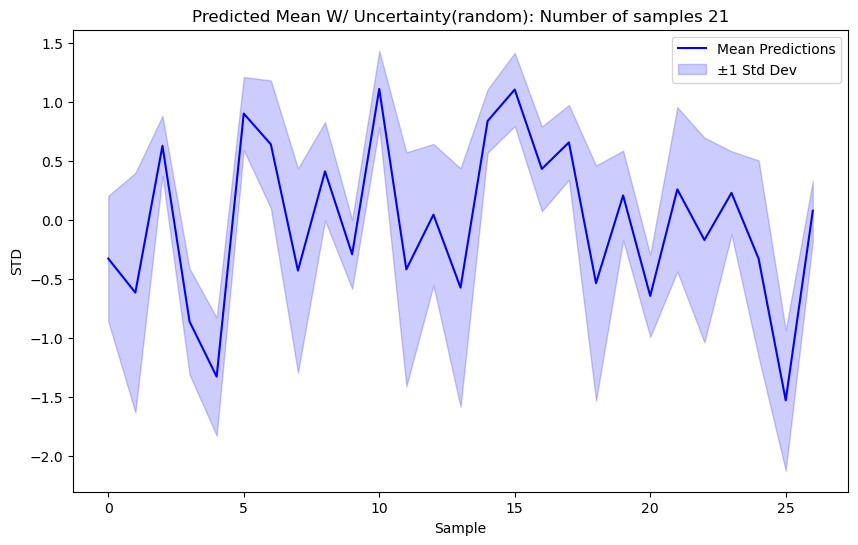

In [69]:
rand_pred_y_np = np.array(rand_pred_mean)  # mean predictions over iterations
rand_pred_std_np = np.array(rand_pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 20
means_rand = rand_pred_y_np[iteration_index]
std_devs_rand = rand_pred_std_np[iteration_index]

# Generate indices for x-axis
x_values_rand = np.arange(len(means_rand))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, means_rand, label='Mean Predictions', color='blue')
plt.fill_between(x_values_rand, means_rand - std_devs_rand, means_rand + std_devs_rand, color='blue', alpha=0.2, label='±1 Std Dev')

plt.title('Predicted Mean W/ Uncertainty(random): Number of samples {}'.format(iteration_index + 1))
plt.xlabel('Sample')
plt.ylabel('STD')
plt.legend()
# plt.grid(True)
plt.show()

In [41]:
pred_std_np = np.array(pred_std)
num_test_points = pred_std_np.shape[1]
num_test_points
len(pred_std)

26

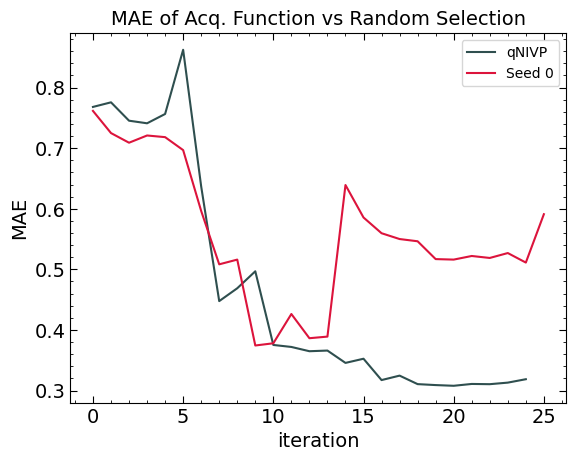

In [160]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
colors = ['crimson', 'blue', 'green', 'orange', 'purple']
for mae_values, seed, colors in zip(random_mae_seeds, random_seeds, colors):
    plt.plot(mae_values, label=f'Seed {seed}', color=colors)

    plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
    plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
    plt.minorticks_on()
    plt.title('MAE of Acq. Function vs Random Selection', size=14)
    plt.xlabel('iteration', size=14)
    plt.ylabel('MAE', size=14)
    plt.legend()
    plt.show()

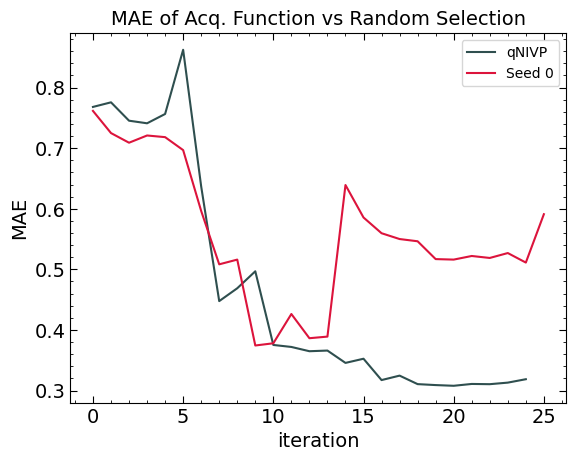

In [156]:
import matplotlib.pyplot as plt

random_seeds = [0, 13, 90, 14, 12]
 # Replace this with your actual lists of MAE values for each seed

plt.plot(pred_mae, color='darkslategray', label='qNIVP')
for mae_values, seed in zip(random_mae_seeds, random_seeds):
    plt.plot(mae_values, label=f'Seed {seed}', color='crimson')

plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection', size=14)
plt.xlabel('iteration', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

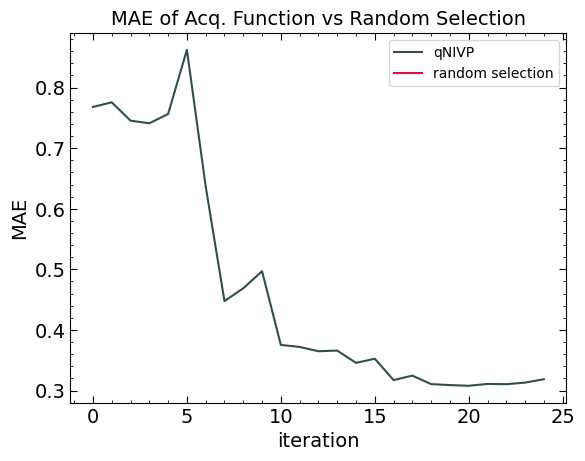

In [121]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(rand_pred_mae, color='crimson', label='random selection')
# plt.plot(ytest, ytest, color='blue')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection',size=14)
plt.xlabel('iteration',size=14)
plt.ylabel('MAE',size=14)
plt.legend()
plt.show()

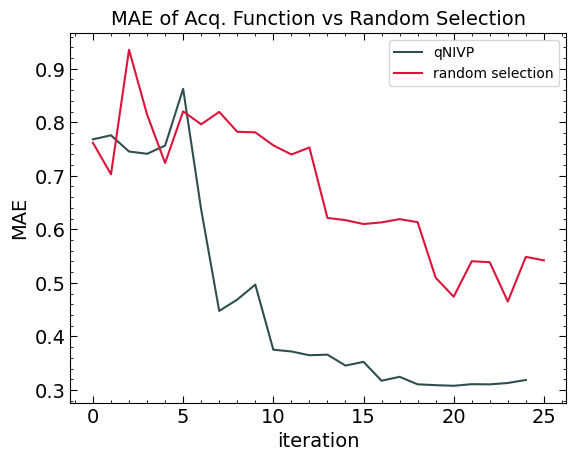

In [117]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(rand_pred_mae, color='crimson', label='random selection')
# plt.plot(ytest, ytest, color='blue')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection',size=14)
plt.xlabel('iteration',size=14)
plt.ylabel('MAE',size=14)
plt.legend()
plt.show()

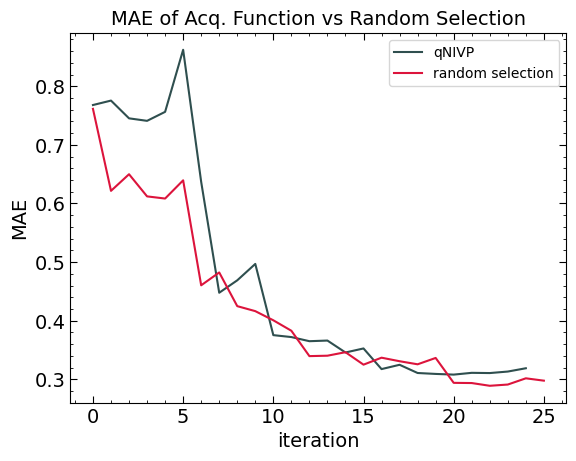

In [114]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(rand_pred_mae, color='crimson', label='random selection')
# plt.plot(ytest, ytest, color='blue')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection',size=14)
plt.xlabel('iteration',size=14)
plt.ylabel('MAE',size=14)
plt.legend()
plt.show()